In [1]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"

/home/a/a270042/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [9]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_nprc     = 64   # number of total processes
parallel_nthread  = 2    # number of threads per worker --> number worker = parallel_nprc/parallel_nthread
parallel_tmem     = 256  # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
# mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
mesh_path         = '/work/ba1264/a270210/model/input/fesom2/dart/'

save_path         = None # '~/tripyview/Results/test_quiv/' #None
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')

input_names   = list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
# input_names.append('TKE')
input_names.append('Tido Test')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl         = None
do_allcycl     = False
vname          = 'temp'
vname_vec      = 'vec+u+v'
do_cgrain      = True # do coarse graining (True) or linear interpolation (False) of u,v data to regular grid
year           = [1979, 2014]
mon            = None
day            = None
record         = None 
box            = None
depth          = 250
do_datavec_r2g = False  # set to False if u,v data are already in geo-coordinates
do_bolus       = False  # add bolus velocity to vec+u+v
dlon, dlat     = 2.0, 2.0

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
proj              = 'rob' 
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 150 #300
save_fmt          = ['png']

In [3]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem,
                                       threads_per_worker=parallel_nthread)

No existing Dask cluster found at: tcp://0.0.0.0:0000


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45211 instead
  warnings.warn(


Started a new Dask client: <Client: 'tcp://127.0.0.1:39639' processes=32 threads=64, memory=214.58 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/a270042/levante-spawner-preset//proxy/45211/status,
Dashboard: /user/a270042/levante-spawner-preset//proxy/45211/status,Workers: 32
Total threads: 64,Total memory: 214.58 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39639,Workers: 32
Dashboard: /user/a270042/levante-spawner-preset//proxy/45211/status,Total threads: 64
Started: Just now,Total memory: 214.58 GiB
Comm: tcp://127.0.0.1:35859,Total threads: 2
Dashboard: /user/a270042/levante-spawner-preset//proxy/41773/status,Memory: 6.71 GiB
Nanny: tcp://127.0.0.1:33059,


In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, ref_path, ref_name = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, ref_path, ref_name, n_cycl, do_allcycl)

#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
    
#______________________________________________________________________________________________________    
# concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

# #______________________________________________________________________________________________________
# # define index regions --> reading shape files
# box = tpv.shortcut_setup_boxregion(box_region)

#______________________________________________________________________________________________________
# use number of worker dependent chunk size for nodes and elements
chunks = dict({'time' : 'auto'    , 
               'elem' : mesh.n2de, #'auto', 
               'nod2' : mesh.n2dn, #'auto', 
               'nz1'  : 1, #mesh.nlev-1, 
               'nz'   : 1, #mesh.nlev, 
               'edg_n': 'auto'}) 

if client is not None:
    # set size limit of time chunks so that size of the total chunks covers 10% of worker memory
    mem_thresh     = 0.08
    worker_info    = client.run_on_scheduler(lambda dask_scheduler: {worker: ws.memory_limit for worker, ws in dask_scheduler.workers.items()})
    mem_limit_byte = next(iter(worker_info.items()))[1]
    print(' --> worker memory      : {:04.2f}Mb'.format(mem_limit_byte/1024**2))
    print(' --> limit chunksize to : {:04.2f}Mb'.format(mem_limit_byte/1024**2*mem_thresh))
    chunk_size = mem_limit_byte * mem_thresh/4 # dive by 4 because we use 4byte single precision
    if   chunks['nod2'] != 'auto': chunk_size = chunk_size/chunks['nod2']    
    elif chunks['elem'] != 'auto': chunk_size = chunk_size/chunks['elem']
    if   chunks['nz']   != 'auto': chunk_size = chunk_size/chunks['nz']
    elif chunks['nz1']  != 'auto': chunk_size = chunk_size/chunks['nz1']
    chunks['time'] = np.int32(np.ceil(chunk_size))
    print(' --> set time chunk size to {:2.2f}% of worker mem.: {:d}'.format(100*mem_thresh, chunks['time']))

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /home/a/a270042/meshcache_tripyview/dart
 > load  *.jlib file: tripyview_fesom2_dart_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /work/ba1264/a270210/model/input/fesom2/dart
 > id              = dart
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 3160340
 > #elem           = 6262485
 > #lvls           = 80
___________________________________________
 --> worker memory      : 6866.46Mb
 --> limit chunksize to : 549.32Mb
 --> set time chunk size to 8.00% of worker mem.: 46


In [5]:
#______________________________________________________________________________________________________________
# do regular binning of diapycnal velocities
Rearth     = 6371e3
if proj in ['ortho', 'nears']: 
    lon_reg    = np.arange(-180, 180+dlon, dlon)
    lat_reg    = np.arange(-90, 90+dlat, dlat)
else:    
    lon_reg    = np.arange(box[0], box[1]+dlon, dlon)
    lat_reg    = np.arange(box[2], box[3]+dlat, dlat)


#______________________________________________________________________________________________________________
# define function for longitudinal binning --> should be possible to parallelize
# this loop since each lon bin is independent
def coarsegrain_over_lon_lat(lon_i_ip1, lat_reg, dlon, dlat, data):
    
    # select all elements that are within longitudinal bin 
    if   'nod2' in list(data.dims): dim_h = 'nod2'
    elif 'elem' in list(data.dims): dim_h = 'elem'
    lonbin = data.isel({dim_h:np.where(((data.lon-lon_i_ip1[0])*(data.lon-lon_i_ip1[1]) <= 0.))[0]}).copy()
    
    # do latitudinal binning within the selected longitudinal bin
    latbin = lonbin.groupby_bins('lat',lat_reg)
    del(lonbin)
    
    # iterate through each bin in latbin and collect the data and compute area sum weighted u,v values 
    # within each lat bin 
    latbin_list = []
    dy, rad     = np.pi*Rearth*dlat/180, np.pi/180
    for bin_ii, latbin_ii in latbin:
        dx        = np.pi*Rearth*dlon/180*np.cos((bin_ii.left+bin_ii.right)/2.0*rad)
        latbin_ii = latbin_ii*latbin_ii['w_A']
        latbin_ii = latbin_ii.sum(dim=dim_h, skipna=True)/dx/dy  
         
        # if u and v are zero set to nan is most likely lsmask
        vnm = list(latbin_ii.data_vars)
        if latbin_ii[vnm[0]].data == 0.0 and latbin_ii[vnm[1]].data == 0.0:
            latbin_ii[vnm[0]].data, latbin_ii[vnm[1]].data = np.nan, np.nan   
        del(vnm)
         
        # give each bin a lat, lon dimension on value --> need for concat along dimension
        latbin_ii = latbin_ii.expand_dims({'lat': np.float32( [(bin_ii.left +bin_ii.right)/2.0] ), 
                                           'lon': np.float32( [(lon_i_ip1[0]+lon_i_ip1[1])/2.0] )
                                          })   
        # add additional dataset coords, binning boundaries and area of lon,lat bin
        latbin_ii = latbin_ii.assign_coords({'lat_bnd':(('lat', 'n2' ), np.float32( [[bin_ii.left , bin_ii.right]] ) ),
                                             'lon_bnd':(('lon', 'n2' ), np.float32( [[lon_i_ip1[0], lon_i_ip1[1]]] ) ), 
                                             'w_A'    :(('lat', 'lon'), np.float32( [[dx*dy                     ]] ) )
                                            })
        
        # make velocity data float32
        latbin_ii = latbin_ii.astype('float32')
        
        # collect each separate lat bin in a list   
        latbin_list.append(latbin_ii) 
            
    del(latbin, latbin_ii) 
    # conncat single latitudinal binning list along lat dimension into combined dataset
    latbin = xr.concat(latbin_list, dim="lat")
    return(latbin)    


#______________________________________________________________________________________________________________
# define function for linear interpolation of velocity data
def interpolate_over_lon_lat(mesh, data_v, lon_reg, lat_reg):
    import matplotlib.tri as mtri
    import matplotlib.pyplot as plt
    
    # create matplotlib triangulation with clean augmented periodic boundaries
    tri   = mtri.Triangulation(np.hstack((mesh.n_x                 , mesh.n_xa)), 
                               np.hstack((mesh.n_y                 , mesh.n_ya)), 
                               np.vstack((mesh.e_i[mesh.e_pbnd_0,:], mesh.e_ia)))
    
    # Creat triangular linear interpolator 
    vnm   = list(data_v.data_vars)
    aux_u = np.hstack(( data_v[vnm[0]].data, data_v[vnm[0]].data[mesh.n_pbnd_a] ))
    aux_v = np.hstack(( data_v[vnm[1]].data, data_v[vnm[1]].data[mesh.n_pbnd_a] ))
    interp_u, interp_v = mtri.LinearTriInterpolator(tri, aux_u ), mtri.LinearTriInterpolator(tri, aux_v )
    del(aux_u, aux_v)

    # Create a regular grid to interpolate onto
    xi, yi       = np.meshgrid(lon_reg, lat_reg)
    
    # Create regular grid u,v xarray dataset
    dict_dat, dict_coord = dict(), dict()
    dict_coord['lon'] = (['lon' ], lon_reg.astype('float32'), dict({'short_name':'Longitude', 'unit':'degree'})) 
    dict_coord['lat'] = (['lat' ], lat_reg.astype('float32'), dict({'short_name':'Latitude' , 'unit':'degree'}))
    dict_dat[vnm[0]]  = (['lat','lon'], interp_u(xi, yi).astype('float32'), data_v[vnm[0]].attrs)
    dict_dat[vnm[1]]  = (['lat','lon'], interp_v(xi, yi).astype('float32'), data_v[vnm[1]].attrs)
    data_v = xr.Dataset(data_vars=dict_dat, coords=dict_coord, attrs=data_v.attrs)
    del(xi, yi, interp_u, interp_v, dict_dat, dict_coord, tri )
    return(data_v)


In [10]:
t0 = clock.time()
# clean up garabage on workers before the party starts!
if client is not None: client.run(gc.collect)
    
#______________________________________________________________________________________________________________
data_list, data_v_list = list(), list()
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    #__________________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record
    
    #__________________________________________________________________________
    input_dict = dict({'year':yeari, 'mon':moni, 'day':dayi, 'record':recordi, 'depth':depth, 
                       'descript':descript, 'do_info':False, 'do_rot':do_datavec_r2g, 'do_ie2n':False, 
                       'do_load':False, 'do_persist':False, 'chunks':chunks, 'do_parallel':do_parallel, 'client':client})
    
    #__________________________________________________________________________________________________________
    # load scalar data
    ts = clock.time()
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, **{**input_dict,'do_load':True})
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load {:s} data: {:3.2f} min.'.format(vname, (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
    
    #__________________________________________________________________________________________________________
    # load vector data e.g. velocity
    ts = clock.time()
    data_v = tpv.load_data_fesom2(mesh, datapath, vname=vname_vec, **input_dict)
    if data_v is None: raise ValueError(f'data_vec == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    # add bolus velocity
    if do_bolus and vname == 'vec+u+v':
        data_v['u'].data = data_v['u'].data + tpv.load_data_fesom2(mesh, datapath, vname='bolus_u', **input_dict)['bolus_u'].data
        data_v['v'].data = data_v['v'].data + tpv.load_data_fesom2(mesh, datapath, vname='bolus_v', **input_dict)['bolus_v'].data
    
    print(' --> elasped time to load {:s} data: {:3.2f} min.'.format(vname_vec, (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data_v.nbytes/(1024**3)))
    print('')

    #___________________________________________________________________________________________________________
    # coarse grain vector data via binning over longitude and latitude
    # do it serial
    if do_cgrain:
        ts = clock.time()
        if not do_parallel:
            lonlatbin = [None]*mlon_reg.size
            for xi in range(0, mlon_reg.size):
                lonlatbin[xi] = coarsegrain_over_lon_lat([lon_reg[xi], lon_reg[xi+1]], lat_reg, dlon, dlat, data_v)
            data_vreg = xr.concat(lonlatbin, dim="lon", coords="minimal", compat='override')
            del(lonlatbin)    
        # do it parallel
        else:
            # from joblib import Parallel, delayed
            # lonlatbin = Parallel(n_jobs=parallel_nprc_bin)(delayed(coarsegrain_over_lon_lat)([lon_reg[xi], lon_reg[xi+1]], lat_reg, dlon, dlat, data_v) for xi in range(0,lon_reg.size-1))
            # data_vreg = xr.concat(lonlatbin, dim="lon", coords="minimal", compat='override')
            # del(lonlatbin)

            # dask solution! already paralelized on chunks
            data_vreg = tpv.coarsegrain_h_dask(data_v, do_parallel, parallel_nprc, dlon=dlon, dlat=dlat, client=client)
        del(data_v)
        print(' --> elasped time to coarse grain data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
        
    # Linear interpolate u,v data to regular grid
    else:
        ts = clock.time()
        data_vreg = interpolate_over_lon_lat(mesh, data_v, lon_reg, lat_reg)
        print(' --> elasped time to interpolate data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    
    #__________________________________________________________________________________________________    
    # create reference data if given 
    if (ii==0) and (ref_path != None):
        data_ref, data_vreg_ref = data, data_vreg
        if do_reffig: 
            data_list.append(data_ref) 
            data_v_list.append(data_vreg_ref) 
        
    #__________________________________________________________________________________________________    
    # compute anomaly 
    if (ref_path != None):
        data_list.append(  tpv.do_anomaly(data  , data_ref  ))  
        data_v_list.append(tpv.do_anomaly(data_vreg, data_vreg_ref))  
    # compute absolute    
    else:
        data_list.append(data)
        data_v_list.append(data_vreg)
    del(data,data_vreg)
    if client is not None: client.run(gc.collect)
    
if (ref_path != None): del(data_ref, data_vreg_ref)
print(' --> total elasped time to process data: {:3.2f} min.'.format( (clock.time()-t0)/60  ))            

0 /work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/ Tido Test
 --> elasped time to load temp data: 0.32 min.
 --> data uses 0.09 Gb:

 --> elasped time to load vec+u+v data: 0.02 min.
 --> data uses 0.15 Gb:

 --> nchunk= 1
 --> rechunk array size --> nchunk_new= 64
 --> elasped time to coarse grain data: 0.79 min.
 --> total elasped time: 1.14 min.


--> cmin/cmax: norm: -1.916710/25.489377, hist: -1.546728/18.953025, fin: -1.546728/18.953025
{'cstr': 'blue2red', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': -1.55, 'cmax': 18.95, 'cref': 10.0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7ffda6a01990>, 'clevel': array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
       11., 12., 13., 14., 15., 16., 17., 18., 19.]), 'clab': array([-2.,  1.,  4.,  7., 10., 13., 16., 19.])}
 --> plot bot    chunk:0|


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/feature/__init__.py:217: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  self._geoms = tuple(geometries)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/feature/__init__.py:217: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  self._geoms = tuple(geometries)


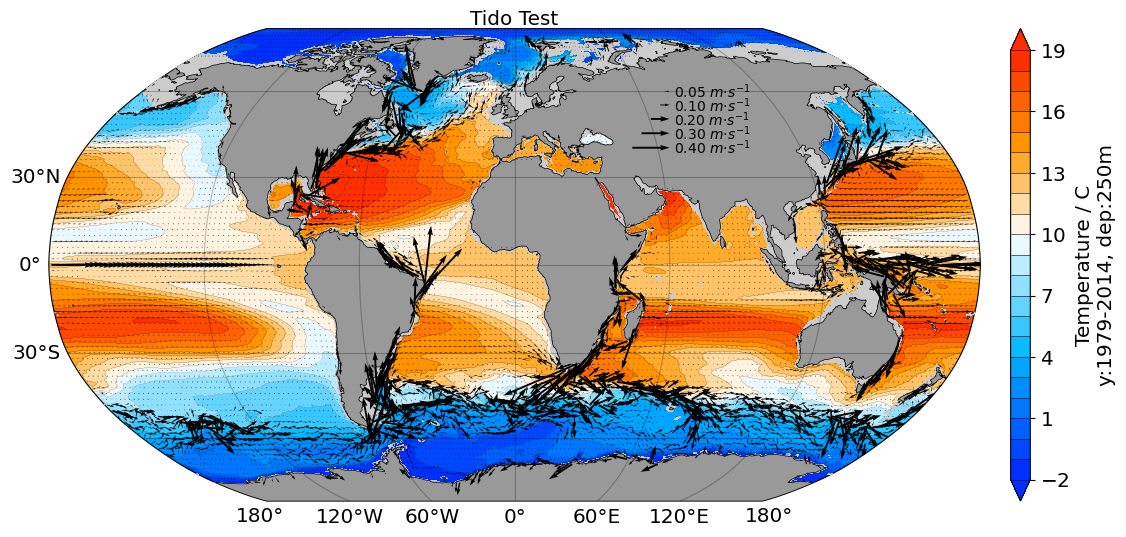

 --> elasped time to plot data: 0.48 min.


In [11]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
ts = clock.time()
ndat   = len(data_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')
    
idx=1 if do_clim else 0       
svname = list(data_list[idx].data_vars)[0]
slabel = data_list[idx][svname].attrs['str_lsave']

#______________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 

#__________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_hslice(mesh, data_list, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,  
                                do_quiver=True, quiver_dat=data_v_list, quiver_opt=dict({'scale':10,}), 
                                do_quiver_leg=True,  quiver_leg_opt=dict({'x':75, 'y':60, 'dy':5, 'dw':10}), 
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':3.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi)  

print(' --> elasped time to plot data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))            

In [ ]:
if do_papermill and do_parallel and client is not None: client.shutdown()